# 🔴 **Import Libs**

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.8 MB/s eta 0:00:00


In [ ]:
!pip install portalocker>=2.0.0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchtext
from torchtext import datasets
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torchdata

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

In [ ]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

Python 3.10.12
2.0.1+cu118
0.15.2+cpu


In [ ]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.0.1+cu118
torchtext --> 0.15.2+cpu
tqdm --> 4.66.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

# 🔴 **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [ ]:
train_set, valid_set, test_set = datasets.WikiText2(root = '/content/',
                                                    split = ('train', 'valid', 'test'))

In [ ]:
train_iter = iter(train_set)
valid_iter = iter(valid_set)
test_iter= iter(test_set)

In [ ]:
next(train_iter)

' \n'

## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [ ]:
tokenizer = get_tokenizer(tokenizer= 'basic_english', language = 'en')

In [ ]:
train_tokens = [tokenizer(line) for line in train_set]
test_tokens = [tokenizer(line) for line in test_set]
valid_tokens = [tokenizer(line) for line in valid_set]

In [ ]:
train_tokens

[[],
 ['=', 'valkyria', 'chronicles', 'iii', '='],
 [],
 ['senjō',
  'no',
  'valkyria',
  '3',
  '<unk>',
  'chronicles',
  '(',
  'japanese',
  '戦場のヴァルキュリア3',
  ',',
  'lit',
  '.',
  'valkyria',
  'of',
  'the',
  'battlefield',
  '3',
  ')',
  ',',
  'commonly',
  'referred',
  'to',
  'as',
  'valkyria',
  'chronicles',
  'iii',
  'outside',
  'japan',
  ',',
  'is',
  'a',
  'tactical',
  'role',
  '@-@',
  'playing',
  'video',
  'game',
  'developed',
  'by',
  'sega',
  'and',
  'media',
  '.',
  'vision',
  'for',
  'the',
  'playstation',
  'portable',
  '.',
  'released',
  'in',
  'january',
  '2011',
  'in',
  'japan',
  ',',
  'it',
  'is',
  'the',
  'third',
  'game',
  'in',
  'the',
  'valkyria',
  'series',
  '.',
  '<unk>',
  'the',
  'same',
  'fusion',
  'of',
  'tactical',
  'and',
  'real',
  '@-@',
  'time',
  'gameplay',
  'as',
  'its',
  'predecessors',
  ',',
  'the',
  'story',
  'runs',
  'parallel',
  'to',
  'the',
  'first',
  'game',
  'and',
  'foll

In [ ]:
vocab_train = build_vocab_from_iterator(train_tokens, specials = ['<unk>'], min_freq= 3)
#vocab_valid = build_vocab_from_iterator(valid_tokens, specials = ['<ukn>'])
#vocab_test = build_vocab_from_iterator(test_tokens, specials = ['<ukn>'])

In [ ]:
vocab_train.set_default_index(index = vocab_train.get_stoi()['<unk>'])

In [ ]:
vocab_train.get_itos()[0]

'<unk>'

In [ ]:
vocab_train.get_stoi()['megawatts']

22241

In [ ]:
len(vocab_train)

28782

In [ ]:
vocab_train.get_stoi()['0']

168

In [ ]:
vocab_train.get_itos()[13667]

'recipe'

## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [ ]:
def basic_wikitext_statistics(iterabledataset):
  num_docs = len([line for line in iterabledataset])

  num_sentences = 0
  num_tokens = 0

  for doc in iterabledataset:
    sentences = doc.split(".") # split document into sentences

    num_sentences += len(sentences)

    for sentence in sentences:
      tokens = sentence.split()
      num_tokens += len(tokens)

  avg_sent_len = num_tokens / num_sentences

  print(f"Number of documents: {num_docs}")
  print(f"Number of words: {num_tokens}")
  print(f"Number of sentences: {num_sentences}")
  print(f"Average sentence length: {avg_sent_len:.2f}")

In [ ]:
basic_wikitext_statistics(train_set)

Number of documents: 36718
Number of words: 1981906
Number of sentences: 120115
Average sentence length: 16.50


In [ ]:
basic_wikitext_statistics(valid_set)

Number of documents: 3760
Number of words: 206427
Number of sentences: 12589
Average sentence length: 16.40


In [ ]:
basic_wikitext_statistics(test_set)

Number of documents: 4358
Number of words: 232793
Number of sentences: 14335
Average sentence length: 16.24


### 🟡 Analyze the most common and least common words in the dataset.

In [ ]:
def token_repetition(tokens_list):
  token_counts = {}

  for token_list in tokens_list:
    for token in token_list:
      if token not in token_counts:
        token_counts[token] = 0
      token_counts[token] +=1

  return token_counts

In [ ]:
token_repetition(train_tokens)

{'=': 29570,
 'valkyria': 54,
 'chronicles': 53,
 'iii': 231,
 'senjō': 5,
 'no': 1702,
 '3': 1601,
 '<unk>': 54625,
 '(': 11992,
 'japanese': 255,
 '戦場のヴァルキュリア3': 3,
 ',': 102615,
 'lit': 29,
 '.': 83397,
 'of': 57030,
 'the': 130768,
 'battlefield': 38,
 ')': 12004,
 'commonly': 119,
 'referred': 206,
 'to': 39521,
 'as': 15058,
 'outside': 309,
 'japan': 212,
 'is': 11691,
 'a': 36523,
 'tactical': 32,
 'role': 598,
 '@-@': 16906,
 'playing': 342,
 'video': 725,
 'game': 2077,
 'developed': 429,
 'by': 12718,
 'sega': 9,
 'and': 50735,
 'media': 262,
 'vision': 87,
 'for': 13794,
 'playstation': 124,
 'portable': 33,
 'released': 979,
 'in': 45015,
 'january': 693,
 '2011': 519,
 'it': 9273,
 'third': 716,
 'series': 1498,
 'same': 979,
 'fusion': 45,
 'real': 271,
 'time': 2607,
 'gameplay': 103,
 'its': 3877,
 'predecessors': 24,
 'story': 545,
 'runs': 194,
 'parallel': 66,
 'first': 4242,
 'follows': 128,
 'nameless': 12,
 'penal': 5,
 'military': 576,
 'unit': 197,
 'serving': 

In [ ]:
sorted_tokens = sorted(token_repetition(train_tokens).items(), key = lambda x: x[1], reverse= True)

print("Most common tokens are sorted below:")
for key, value in sorted_tokens[:6]:
  print(f'{key} : {value}')

print('----------------------------')

print("least common tokens are sorted below:")
for key, value in sorted_tokens[-6:]:
  print(f'{key} : {value}')

Most common tokens are sorted below:
the : 130768
, : 102615
. : 83397
of : 57030
<unk> : 54625
and : 50735
----------------------------
least common tokens are sorted below:
zoromski : 3
roundabouts : 3
tuscola : 3
northeasterly : 3
intergrades : 3
gallinae : 3


### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

In [ ]:
df = pd.DataFrame.from_dict(token_repetition(train_tokens), orient='index', columns=['count'])
df.index.name = 'token'
df = df.reset_index()

df

,token,count
0,=,29570
1,valkyria,54
2,chronicles,53
3,iii,231
4,senjō,5
...,...,...
28777,spotless,7
28778,zetlandicus,4
28779,intergrades,3
28780,flea,4


In [ ]:
df_sorted = df.sort_values('count', axis = 0, ascending= False)

df_top_20 = df_sorted.head(20)

df_least_20 = df_sorted.tail(20)

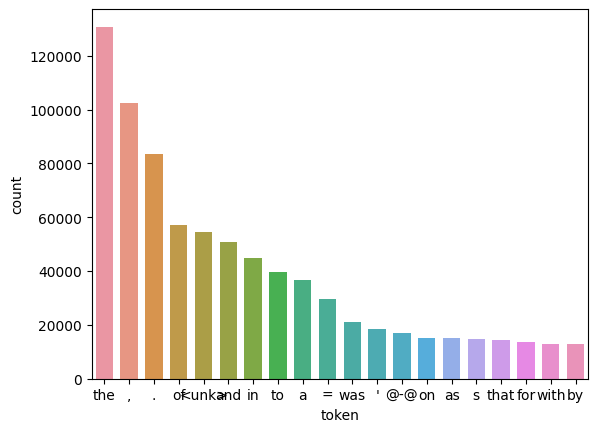

In [ ]:
sns.barplot(data = df_top_20, x = 'token', y = 'count', width = .7);

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [ ]:
def data_process(raw_text_iter, seq_len):
  data = torch.cat(([torch.LongTensor(vocab_train(tokenizer(line))) for line in raw_text_iter]))

  row = len(data) // seq_len

  input = data[: row * seq_len]
  target = torch.cat((data, torch.tensor([0])), dim = 0)

  target = target[1: row * seq_len + 1]


  input = input.view(row, seq_len)
  target = target.view(row, seq_len)

  return input, target

In [ ]:
data_process(train_set, seq_len= 120)

(tensor([[    9,  3849,  3869,  ...,   598,     5,    34],
         [13620,   120,     1,  ...,   518,     3,    45],
         [  320,     2,    24,  ...,     6,  2633,   120],
         ...,
         [    7,     1,  1578,  ...,    11,  2851,     0],
         [   11,  6859,   385,  ...,    21,  1261,     3],
         [20530,    20,   887,  ...,     0,     3,    41]]),
 tensor([[ 3849,  3869,   881,  ...,     5,    34, 13620],
         [  120,     1,  2321,  ...,     3,    45,   320],
         [    2,    24,   203,  ...,  2633,   120,  1814],
         ...,
         [    1,  1578,     0,  ...,  2851,     0,    11],
         [ 6859,   385,    11,  ...,  1261,     3, 20530],
         [   20,   887,    33,  ...,     3,    41, 13667]]))

In [ ]:
seq_len = 35

X_train, y_train = data_process(train_set, seq_len= 35)
X_test, y_test = data_process(test_set, seq_len= 35)
X_valid, y_valid = data_process(valid_set, seq_len= 35)



print(f"Preprocessed datas shapes respectively are:\n X_train: {X_train.shape}- y_train: {y_train.shape}\n X_test: {X_test.shape} - y_test: {y_test.shape}\n X_valid: {X_valid.shape} - y_valid: {y_valid.shape}")

Preprocessed datas shapes respectively are:
 X_train: torch.Size([58571, 35])- y_train: torch.Size([58571, 35])
 X_test: torch.Size([6910, 35]) - y_test: torch.Size([6910, 35])
 X_valid: torch.Size([6126, 35]) - y_valid: torch.Size([6126, 35])


In [ ]:
X_train.shape

torch.Size([58571, 35])

In [ ]:
X_train

tensor([[    9,  3849,  3869,  ...,   976,     2,    23],
        [    8,  5790,   299,  ...,     1,  3849,    93],
        [    3,     0,     1,  ...,  1063,  2082,     1],
        ...,
        [   83,  1180,    17,  ...,   323,    16, 23206],
        [   49,  3037,     6,  ...,   482,  1394,     2],
        [  137,    24,    23,  ...,   296,    33,   419]])

In [ ]:
y_train

tensor([[ 3849,  3869,   881,  ...,     2,    23,     8],
        [ 5790,   299,    12,  ...,  3849,    93,     3],
        [    0,     1,   156,  ...,  2082,     1,  1702],
        ...,
        [ 1180,    17,     1,  ...,    16, 23206,    49],
        [ 3037,     6, 12886,  ...,  1394,     2,   137],
        [   24,    23,     0,  ...,    33,   419,    14]])

In [ ]:
X_train[0]

tensor([    9,  3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,
         3869,    21,   780, 28780,     2,  6182,     3,  3849,     4,     1,
         5023,    88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,
          881,   629,   976,     2,    23])

In [ ]:
y_train[0]

tensor([ 3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,  3869,
           21,   780, 28780,     2,  6182,     3,  3849,     4,     1,  5023,
           88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,   881,
          629,   976,     2,    23,     8])

## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [ ]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    inputs_line = self.inputs[idx]
    targets_line = self.targets[idx]

    return inputs_line, targets_line

In [ ]:
train_dataset = LanguageModelDataset(X_train, y_train)
len(train_dataset)
train_dataset[0]

(tensor([    9,  3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,
          3869,    21,   780, 28780,     2,  6182,     3,  3849,     4,     1,
          5023,    88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,
           881,   629,   976,     2,    23]),
 tensor([ 3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,  3869,
            21,   780, 28780,     2,  6182,     3,  3849,     4,     1,  5023,
            88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,   881,
           629,   976,     2,    23,     8]))

In [ ]:
train_dataset = LanguageModelDataset(X_train, y_train)
test_dataset = LanguageModelDataset(X_test, y_test)
valid_dataset = LanguageModelDataset(X_valid, y_valid)

## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 20, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 20, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 20, shuffle = True)

In [ ]:
next(iter(train_loader))[0].shape

torch.Size([20, 35])

# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [ ]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, dropout_rnn,  batch_first):
    super().__init__()

    self.embedding_layer = nn.Embedding(num_embeddings = len(vocab_size),
                                        embedding_dim= embedding_dim)

    self.dropout = nn.Dropout(p = dropout_rate)

    self.lstm = nn.LSTM(input_size = embedding_dim,
                        hidden_size = hidden_dim,
                        num_layers = num_layers,
                        batch_first = batch_first,
                        dropout = dropout_rnn)

    self.clf = nn.Linear(in_features= hidden_dim, out_features= len(vocab_size))



  def forward(self, src):
    y = self.dropout(self.embedding_layer(src))

    o, h = self.lstm(y)

    output = self.clf(o)

    return output


In [ ]:
test_data = torch.randint(1, len(vocab_train), (32, 60))
test_data.shape

torch.Size([32, 60])

In [ ]:
test_data

tensor([[20545,   214,  1908,  ..., 15094, 22537,   606],
        [12135, 16511, 12011,  ...,  8043, 23782, 12868],
        [ 4341,  3012, 10376,  ..., 26121,  6693,  5697],
        ...,
        [ 2773, 23622,  2311,  ...,   895, 25208,  6794],
        [ 7346, 27028, 26211,  ..., 15950, 23233, 23295],
        [23936, 18025, 26304,  ..., 16634, 11964, 28371]])

In [ ]:
model = LanguageModel(vocab_size= vocab_train,
                      embedding_dim = 64,
                      hidden_dim = 128,
                      num_layers = 2,
                      dropout_rate=0.5,
                      dropout_rnn = 0.2,
                      batch_first = True)

In [ ]:
model(test_data).shape

torch.Size([32, 60, 28782])

In [ ]:
num_trainable_params(model), num_trainable_params(model.embedding_layer), num_trainable_params(model.lstm), num_trainable_params(model.clf)

(5.78635, 1.842048, 0.231424, 3.712878)

# 🔴 **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
vocab_size= vocab_train
embedding_dim = 64
hidden_dim = 128
num_layers = 1
dropout_rate=0.5
dropout_rnn = .2
batch_first = True

lr = 0.9
wd = 1e-5

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [ ]:
model = model.to(device)

optimizer = optim.SGD(params = model.parameters(), lr = 0.1, momentum = .9, weight_decay = 1e-5, nesterov = True)

loss_fn = nn.CrossEntropyLoss()

perp = tm.text.Perplexity()

In [ ]:
clip = 0.25

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, clip, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.to(device)
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      loss.backward()

      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm = clip)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.to(device)
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model = model.to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

print(loss)

tensor(10.2677, device='cuda:0')


In [ ]:
torch.cuda.empty_cache()

### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
model = LanguageModel(vocab_size= vocab_train,
                      embedding_dim = 300,
                      hidden_dim = 512,
                      num_layers = 2,
                      dropout_rate=0.5,
                      dropout_rnn = .2,
                      batch_first = True).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)

In [ ]:
subset_size = 1500
_, mini_train_data = random_split(train_dataset, (len(train_dataset)-subset_size, subset_size))
mini_train_loader = DataLoader(mini_train_data, batch_size= 32)

In [ ]:
num_epochs = 120
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, perp, clip, epoch)

Epoch 112:  87%|████████▋ | 41/47 [00:03<00:00, 12.01batch/s, loss=1.18, metric=3.27]


KeyboardInterrupt: ignored

### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 2

for lr in [0.9, 0.5, 0.25, .01]:
  print(f'LR={lr}')

  model = LanguageModel(vocab_size= vocab_train,
                      embedding_dim = 300,
                      hidden_dim = 512,
                      num_layers = 2,
                      dropout_rate=0.5,
                      dropout_rnn = .2,
                      batch_first = True).to(device)

  model = torch.load('/content/model.pt')
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, perp, clip, epoch)

  print()

LR=0.9


Epoch 1: 100%|██████████| 2929/2929 [01:52<00:00, 25.96batch/s, loss=4.15, metric=63.2]



LR=0.5


Epoch 1: 100%|██████████| 2929/2929 [01:51<00:00, 26.26batch/s, loss=4.12, metric=61.8]



LR=0.25


Epoch 1: 100%|██████████| 2929/2929 [01:54<00:00, 25.51batch/s, loss=4.13, metric=62.1]



LR=0.01


 29%|██▊       | 835/2929 [00:30<01:16, 27.21batch/s, loss=4.33, metric=75.7]


KeyboardInterrupt: ignored

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs = 1

for lr in [.6, .5, .4,]:
  for wd in [1e-4, 1e-5,1e-6]:
    print(f'LR={lr}, WD={wd}')

    model = LanguageModel(vocab_size= vocab_train,
                      embedding_dim = 300,
                      hidden_dim = 512,
                      num_layers = 2,
                      dropout_rate=0.5,
                      dropout_rnn = .2,
                      batch_first = True).to(device)

    model = torch.load('/content/model.pt')
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, perp, clip, epoch)

    print()

LR=0.6, WD=0.0001


100%|██████████| 2929/2929 [01:45<00:00, 27.80batch/s, loss=4.28, metric=71.9]



LR=0.6, WD=1e-05


100%|██████████| 2929/2929 [01:45<00:00, 27.83batch/s, loss=4.24, metric=69.5]



LR=0.6, WD=1e-06


100%|██████████| 2929/2929 [01:44<00:00, 27.96batch/s, loss=4.24, metric=69.4]



LR=0.5, WD=0.0001


100%|██████████| 2929/2929 [01:44<00:00, 27.91batch/s, loss=4.27, metric=71.8]



LR=0.5, WD=1e-05


100%|██████████| 2929/2929 [01:45<00:00, 27.85batch/s, loss=4.25, metric=69.9]



LR=0.5, WD=1e-06


100%|██████████| 2929/2929 [01:45<00:00, 27.89batch/s, loss=4.25, metric=69.8]



LR=0.4, WD=0.0001


100%|██████████| 2929/2929 [01:44<00:00, 27.96batch/s, loss=4.27, metric=71.8]



LR=0.4, WD=1e-05


 44%|████▍     | 1298/2929 [00:46<00:58, 27.92batch/s, loss=4.28, metric=72.2]


KeyboardInterrupt: ignored

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model =

In [ ]:
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Main Loop

🔰 Define model.

In [ ]:
model = LanguageModel(vocab_size= vocab_train,
                      embedding_dim = 300,
                      hidden_dim = 512,
                      num_layers = 2,
                      dropout_rate=0.5,
                      dropout_rnn = .2,
                      batch_first = True).to(device)

In [ ]:
model = torch.load('/content/model.pt')

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
lr = .5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    perp,
                                                    clip,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 2929/2929 [01:51<00:00, 26.23batch/s, loss=4.23, metric=68.7]


Model Saved!
Valid: Loss = 4.978, Metric = 145.2



Epoch 1: 100%|██████████| 2929/2929 [01:55<00:00, 25.32batch/s, loss=4.22, metric=67.9]


Model Saved!
Valid: Loss = 4.947, Metric = 140.8



Epoch 2: 100%|██████████| 2929/2929 [01:55<00:00, 25.28batch/s, loss=4.25, metric=70]


Model Saved!
Valid: Loss = 4.929, Metric = 138.3



Epoch 3: 100%|██████████| 2929/2929 [01:55<00:00, 25.36batch/s, loss=4.29, metric=72.6]


Model Saved!
Valid: Loss = 4.924, Metric = 137.6



Epoch 4: 100%|██████████| 2929/2929 [01:55<00:00, 25.44batch/s, loss=4.32, metric=75.3]


Model Saved!
Valid: Loss = 4.917, Metric = 136.6



Epoch 5: 100%|██████████| 2929/2929 [01:55<00:00, 25.27batch/s, loss=4.35, metric=77.7]


Model Saved!
Valid: Loss = 4.908, Metric = 135.4



Epoch 6: 100%|██████████| 2929/2929 [01:55<00:00, 25.26batch/s, loss=4.38, metric=79.9]


Model Saved!
Valid: Loss = 4.904, Metric = 134.8



Epoch 7:  67%|██████▋   | 1954/2929 [01:17<00:38, 25.10batch/s, loss=4.38, metric=79.6]


KeyboardInterrupt: ignored

## 🟠 Plot

In [ ]:
loss_train_hist_total = torch.save(torch.tensor(loss_train_hist),f = 'loss_train_hist_total.pt')
loss_test_hist_total = torch.save(torch.tensor(loss_valid_hist),f = 'loss_test_hist_total.pt')

metric_train_hist_total = torch.save(torch.tensor(metric_train_hist),f = 'metric_train_hist_total.pt')
metric_valid_hist_total = torch.save(torch.tensor(metric_valid_hist),f = 'metric_valid_hist_total.pt')

🔰 Plot learning curves

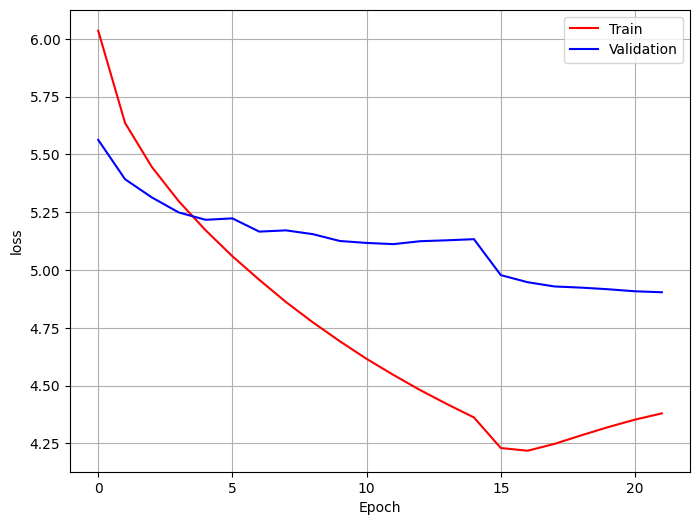

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

In [ ]:
best_model = torch.load('/content/model.pt')

best_model.eval()

LanguageModel(
  (embedding_layer): Embedding(28782, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
  (clf): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
loss_test, metric_test= evaluate(best_model, test_loader, loss_fn, perp)
loss_valid, metric_test = evaluate(best_model, valid_loader, loss_fn, perp)

metric_test, metric_valid

(134.84213256835938, 134.8424530029297)

# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
    pass